In [4]:
#@title DCGAN de colores - CIFAR10 🎨
import os, math, time, random
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
epochs = 25
batch_size = 128
lr = 0.0002
beta1 = 0.5
out_dir = "/content/samples_color_gan"
os.makedirs(out_dir, exist_ok=True)


In [5]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
dataset = datasets.CIFAR10(root="/content/data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)


100%|██████████| 170M/170M [00:02<00:00, 72.1MB/s]


In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=3, feature_g=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_g*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g*8), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g*8, feature_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*4), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g*4, feature_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*2), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g*2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, channels=3, feature_d=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d*2, feature_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d*4, feature_d*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x): return self.net(x).view(-1, 1)


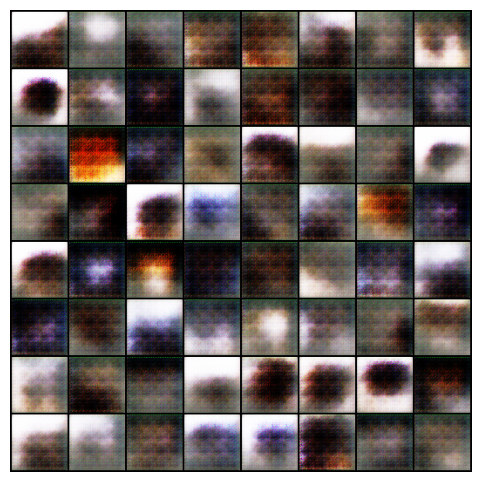

✅ Época 1/25 - Loss_D: 1.369, Loss_G: 2.488


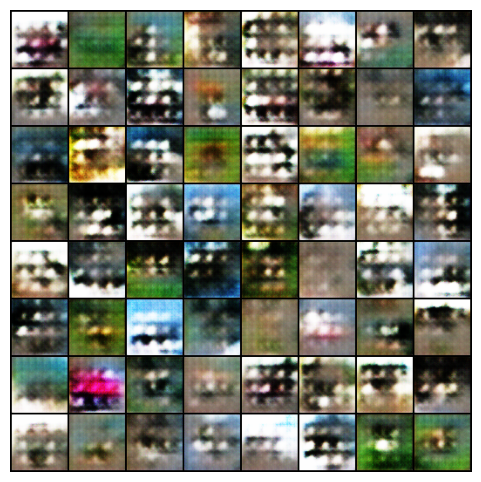

✅ Época 2/25 - Loss_D: 0.302, Loss_G: 2.572


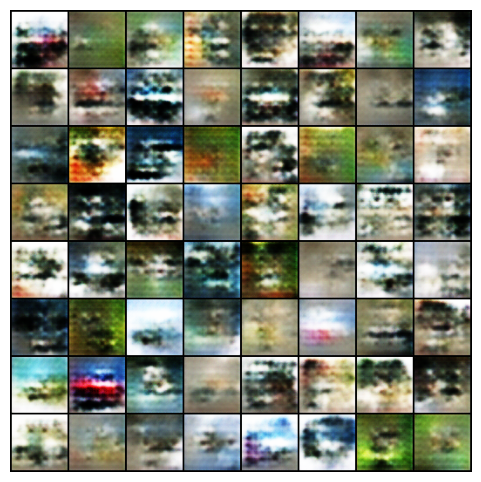

✅ Época 3/25 - Loss_D: 0.311, Loss_G: 2.427


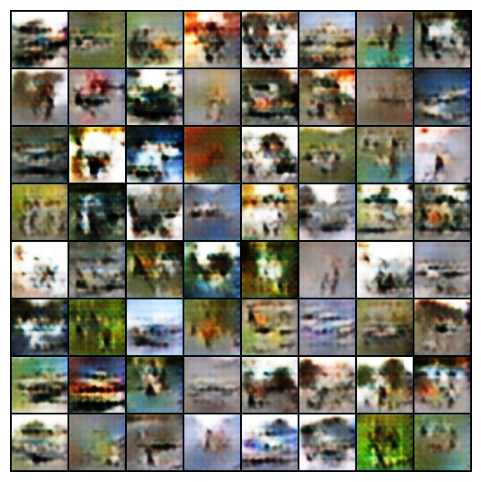

✅ Época 4/25 - Loss_D: 0.494, Loss_G: 3.467


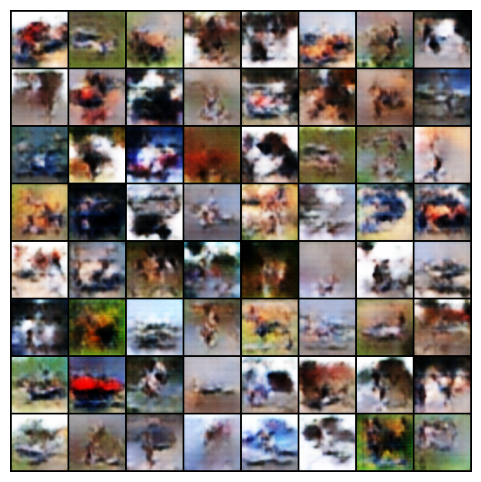

✅ Época 5/25 - Loss_D: 0.529, Loss_G: 1.340


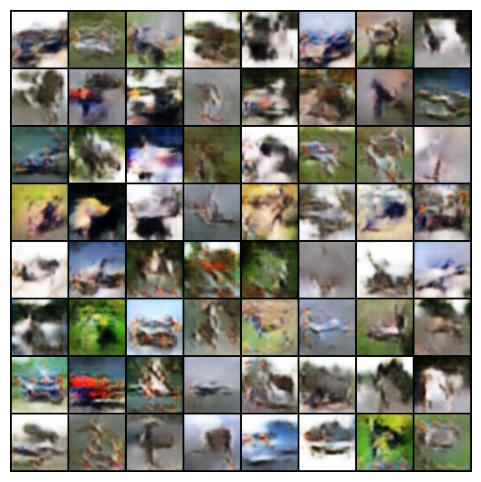

✅ Época 6/25 - Loss_D: 0.272, Loss_G: 2.566


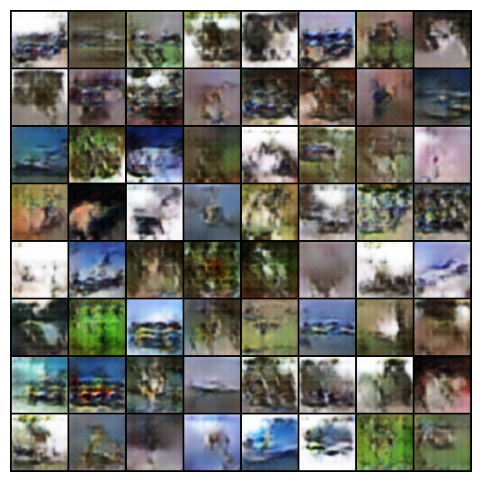

✅ Época 7/25 - Loss_D: 0.606, Loss_G: 2.901


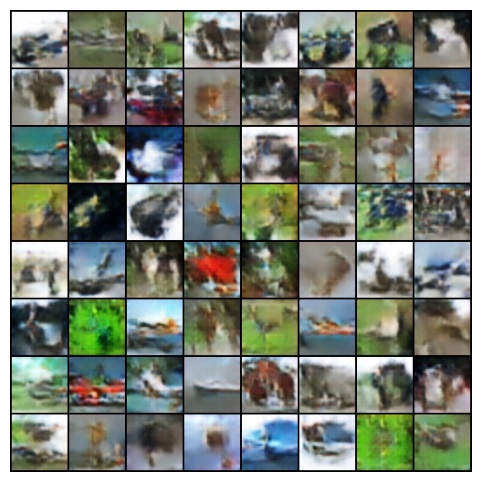

✅ Época 8/25 - Loss_D: 0.207, Loss_G: 3.373


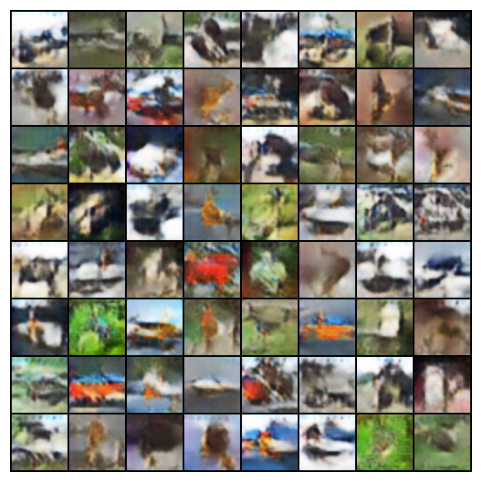

✅ Época 9/25 - Loss_D: 0.170, Loss_G: 6.134


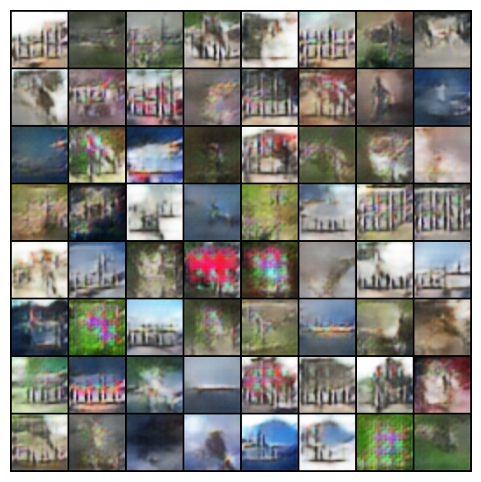

✅ Época 10/25 - Loss_D: 0.174, Loss_G: 5.146


In [ ]:
G, D = Generator().to(device), Discriminator().to(device)
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

for epoch in range(1, epochs+1):
    for real, _ in loader:
        real = real.to(device)
        bsz = real.size(0)
        real_labels = torch.full((bsz,1), 0.9, device=device)
        fake_labels = torch.zeros(bsz,1, device=device)

        # --- D ---
        z = torch.randn(bsz, latent_dim, 1, 1, device=device)
        fake = G(z).detach()
        loss_D = (criterion(D(real), real_labels) + criterion(D(fake), fake_labels)) / 2
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # --- G ---
        z = torch.randn(bsz, latent_dim, 1, 1, device=device)
        fake = G(z)
        loss_G = criterion(D(fake), real_labels)
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

    # Muestra de la época
    with torch.no_grad():
        G.eval()
        fake = G(fixed_noise).detach().cpu()
        grid = utils.make_grid((fake + 1) / 2, nrow=8)
        utils.save_image(grid, f"{out_dir}/epoch_{epoch:03d}.png")
        plt.figure(figsize=(6,6)); plt.axis("off"); plt.imshow(grid.permute(1,2,0)); plt.show()
    G.train()
    print(f"✅ Época {epoch}/{epochs} - Loss_D: {loss_D:.3f}, Loss_G: {loss_G:.3f}")


# New Section

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
